# LSTM Travel Time + Speed Prediction - N101.3

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'N101.4')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6397,75,37,2021042800
6411,75,37,2021042800
6425,75,37,2021042800
6439,75,37,2021042800
6453,75,37,2021042800
...,...,...,...
294408,74,38,2021051509
294422,74,38,2021051509
294436,74,38,2021051509
294450,74,38,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,75.0,37.0
2021042801,75.0,37.0
2021042802,75.0,37.0
2021042803,75.0,37.0
2021042804,75.0,37.0
...,...,...
2021051505,74.0,38.0
2021051506,74.0,38.0
2021051507,74.0,38.0


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed

,currentSpeed
timeStamp,
2021042800,1.000000
2021042801,1.000000
2021042802,1.000000
2021042803,1.000000
2021042804,1.000000
...,...
2021051505,0.929117
2021051506,0.929117
2021051507,0.929117


# LSTM - Time

In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Rmsprop', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1], 1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 7s 731ms/step - loss: 0.6452 - mae: 0.6228 - rmse: 0.5833 - val_loss: 0.0840 - val_mae: 0.0840 - val_rmse: 0.0840
Epoch 2/300
3/3 [==============================] - 0s 71ms/step - loss: 0.2479 - mae: 0.0860 - rmse: 0.2270 - val_loss: 0.0638 - val_mae: 0.0638 - val_rmse: 0.0638
Epoch 3/300
3/3 [==============================] - 0s 67ms/step - loss: 0.2374 - mae: 0.0839 - rmse: 0.2238 - val_loss: 0.0855 - val_mae: 0.0855 - val_rmse: 0.0855
Epoch 4/300
3/3 [==============================] - 0s 66ms/step - loss: 0.2486 - mae: 0.0864 - rmse: 0.2284 - val_loss: 0.0852 - val_mae: 0.0852 - val_rmse: 0.0852
Epoch 5/300
3/3 [==============================] - 0s 69ms/step - loss: 0.2484 - mae: 0.0867 - rmse: 0.2280 - val_loss: 0.0843 - val_mae: 0.0843 - val_rmse: 0.0843
Epoch 6/300
3/3 [==============================] - 0s 68ms/step - loss: 0.2480 - mae: 0.0862 - rmse: 0.2275 - val_loss: 0.0807 - val_mae: 0.0807 - val_rmse: 0.0807
Epoch 7/300
3/3

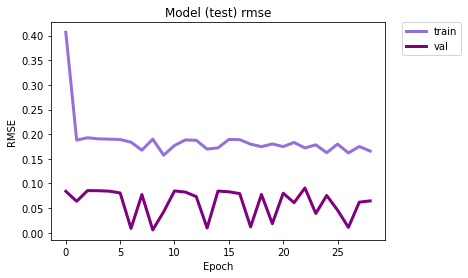

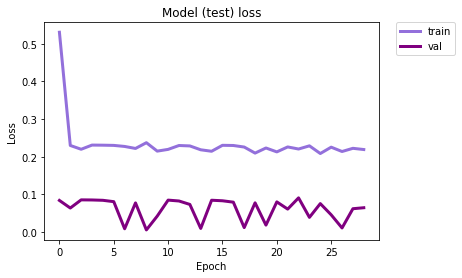

Epoch 1/300
5/5 [==============================] - 0s 70ms/step - loss: 0.2551 - mae: 0.1314 - rmse: 0.2334 - val_loss: 0.0502 - val_mae: 0.0472 - val_rmse: 0.0502
Epoch 2/300
5/5 [==============================] - 0s 61ms/step - loss: 0.2556 - mae: 0.1260 - rmse: 0.2290 - val_loss: 0.0480 - val_mae: 0.0447 - val_rmse: 0.0480
Epoch 3/300
5/5 [==============================] - 0s 55ms/step - loss: 0.2550 - mae: 0.1204 - rmse: 0.2319 - val_loss: 0.0455 - val_mae: 0.0417 - val_rmse: 0.0455
Epoch 4/300
5/5 [==============================] - 0s 60ms/step - loss: 0.2567 - mae: 0.1188 - rmse: 0.2330 - val_loss: 0.0451 - val_mae: 0.0413 - val_rmse: 0.0451
Epoch 5/300
5/5 [==============================] - 0s 62ms/step - loss: 0.2533 - mae: 0.1164 - rmse: 0.2258 - val_loss: 0.0464 - val_mae: 0.0427 - val_rmse: 0.0464
Epoch 6/300
5/5 [==============================] - 0s 55ms/step - loss: 0.2599 - mae: 0.1211 - rmse: 0.2356 - val_loss: 0.0452 - val_mae: 0.0414 - val_rmse: 0.0452
Epoch 7/300
5/5 

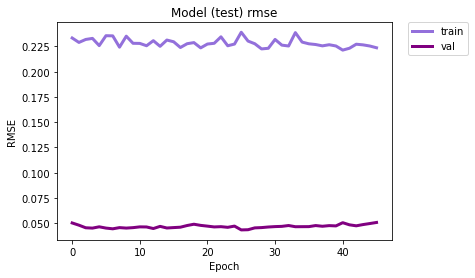

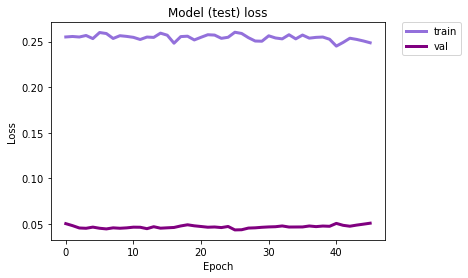

Epoch 1/300
7/7 [==============================] - 0s 62ms/step - loss: 0.1927 - mae: 0.0970 - rmse: 0.1762 - val_loss: 0.0519 - val_mae: 0.0451 - val_rmse: 0.0530
Epoch 2/300
7/7 [==============================] - 0s 54ms/step - loss: 0.1892 - mae: 0.0933 - rmse: 0.1743 - val_loss: 0.0530 - val_mae: 0.0446 - val_rmse: 0.0554
Epoch 3/300
7/7 [==============================] - 0s 63ms/step - loss: 0.1899 - mae: 0.0912 - rmse: 0.1743 - val_loss: 0.0537 - val_mae: 0.0444 - val_rmse: 0.0568
Epoch 4/300
7/7 [==============================] - 0s 65ms/step - loss: 0.1929 - mae: 0.0927 - rmse: 0.1765 - val_loss: 0.0547 - val_mae: 0.0441 - val_rmse: 0.0586
Epoch 5/300
7/7 [==============================] - 0s 65ms/step - loss: 0.1894 - mae: 0.0894 - rmse: 0.1734 - val_loss: 0.0543 - val_mae: 0.0442 - val_rmse: 0.0580
Epoch 6/300
7/7 [==============================] - 0s 63ms/step - loss: 0.1921 - mae: 0.0936 - rmse: 0.1758 - val_loss: 0.0549 - val_mae: 0.0440 - val_rmse: 0.0590
Epoch 7/300
7/7 

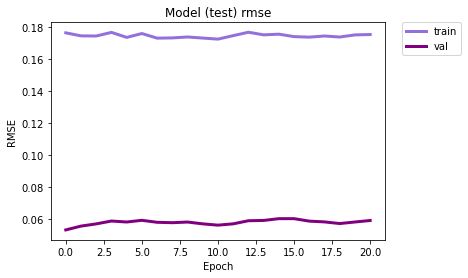

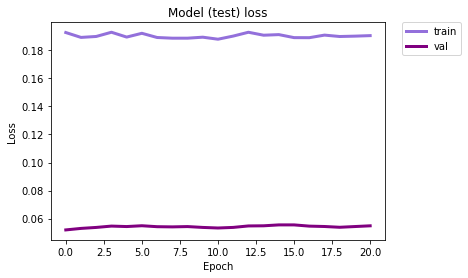

Epoch 1/300
9/9 [==============================] - 1s 59ms/step - loss: 0.1572 - mae: 0.0828 - rmse: 0.1487 - val_loss: 0.0340 - val_mae: 0.0276 - val_rmse: 0.0313
Epoch 2/300
9/9 [==============================] - 1s 57ms/step - loss: 0.1569 - mae: 0.0814 - rmse: 0.1493 - val_loss: 0.0331 - val_mae: 0.0262 - val_rmse: 0.0303
Epoch 3/300
9/9 [==============================] - 0s 56ms/step - loss: 0.1576 - mae: 0.0808 - rmse: 0.1495 - val_loss: 0.0319 - val_mae: 0.0241 - val_rmse: 0.0289
Epoch 4/300
9/9 [==============================] - 0s 53ms/step - loss: 0.1565 - mae: 0.0800 - rmse: 0.1482 - val_loss: 0.0321 - val_mae: 0.0245 - val_rmse: 0.0291
Epoch 5/300
9/9 [==============================] - 0s 55ms/step - loss: 0.1555 - mae: 0.0809 - rmse: 0.1469 - val_loss: 0.0335 - val_mae: 0.0268 - val_rmse: 0.0307
Epoch 6/300
9/9 [==============================] - 0s 56ms/step - loss: 0.1568 - mae: 0.0817 - rmse: 0.1483 - val_loss: 0.0333 - val_mae: 0.0266 - val_rmse: 0.0306
Epoch 7/300
9/9 

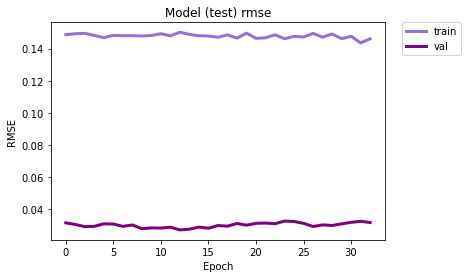

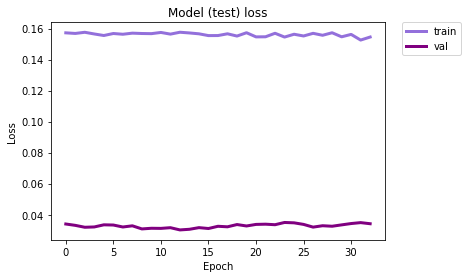

Epoch 1/300
11/11 [==============================] - 1s 62ms/step - loss: 0.1369 - mae: 0.0717 - rmse: 0.1329 - val_loss: 0.0461 - val_mae: 0.0415 - val_rmse: 0.0460
Epoch 2/300
11/11 [==============================] - 1s 62ms/step - loss: 0.1345 - mae: 0.0719 - rmse: 0.1305 - val_loss: 0.0430 - val_mae: 0.0410 - val_rmse: 0.0431
Epoch 3/300
11/11 [==============================] - 1s 55ms/step - loss: 0.1360 - mae: 0.0745 - rmse: 0.1313 - val_loss: 0.0431 - val_mae: 0.0410 - val_rmse: 0.0431
Epoch 4/300
11/11 [==============================] - 1s 56ms/step - loss: 0.1344 - mae: 0.0741 - rmse: 0.1302 - val_loss: 0.0430 - val_mae: 0.0409 - val_rmse: 0.0430
Epoch 5/300
11/11 [==============================] - 1s 61ms/step - loss: 0.1376 - mae: 0.0744 - rmse: 0.1335 - val_loss: 0.0436 - val_mae: 0.0411 - val_rmse: 0.0435
Epoch 6/300
11/11 [==============================] - 1s 54ms/step - loss: 0.1383 - mae: 0.0766 - rmse: 0.1342 - val_loss: 0.0444 - val_mae: 0.0412 - val_rmse: 0.0443
Epoc

11/11 [==============================] - 1s 80ms/step - loss: 0.1338 - mae: 0.0736 - rmse: 0.1293 - val_loss: 0.0418 - val_mae: 0.0405 - val_rmse: 0.0419
Epoch 51/300
11/11 [==============================] - 1s 103ms/step - loss: 0.1348 - mae: 0.0749 - rmse: 0.1305 - val_loss: 0.0417 - val_mae: 0.0405 - val_rmse: 0.0417
Epoch 52/300
11/11 [==============================] - 1s 107ms/step - loss: 0.1344 - mae: 0.0759 - rmse: 0.1303 - val_loss: 0.0418 - val_mae: 0.0405 - val_rmse: 0.0419
Epoch 53/300
11/11 [==============================] - 1s 93ms/step - loss: 0.1343 - mae: 0.0738 - rmse: 0.1299 - val_loss: 0.0416 - val_mae: 0.0404 - val_rmse: 0.0417
Epoch 54/300
11/11 [==============================] - 1s 86ms/step - loss: 0.1365 - mae: 0.0769 - rmse: 0.1318 - val_loss: 0.0422 - val_mae: 0.0405 - val_rmse: 0.0423
Epoch 55/300
11/11 [==============================] - 1s 90ms/step - loss: 0.1339 - mae: 0.0746 - rmse: 0.1292 - val_loss: 0.0420 - val_mae: 0.0405 - val_rmse: 0.0420
Epoch 56/

11/11 [==============================] - 1s 86ms/step - loss: 0.1343 - mae: 0.0741 - rmse: 0.1299 - val_loss: 0.0413 - val_mae: 0.0401 - val_rmse: 0.0414
Epoch 100/300
11/11 [==============================] - 1s 85ms/step - loss: 0.1334 - mae: 0.0744 - rmse: 0.1289 - val_loss: 0.0412 - val_mae: 0.0401 - val_rmse: 0.0413
Epoch 101/300
11/11 [==============================] - 1s 90ms/step - loss: 0.1328 - mae: 0.0732 - rmse: 0.1276 - val_loss: 0.0410 - val_mae: 0.0400 - val_rmse: 0.0411
Epoch 102/300
11/11 [==============================] - 1s 84ms/step - loss: 0.1332 - mae: 0.0744 - rmse: 0.1292 - val_loss: 0.0416 - val_mae: 0.0401 - val_rmse: 0.0416
Epoch 103/300
11/11 [==============================] - 1s 83ms/step - loss: 0.1349 - mae: 0.0748 - rmse: 0.1304 - val_loss: 0.0414 - val_mae: 0.0401 - val_rmse: 0.0415
Epoch 104/300
11/11 [==============================] - 1s 80ms/step - loss: 0.1339 - mae: 0.0746 - rmse: 0.1295 - val_loss: 0.0412 - val_mae: 0.0400 - val_rmse: 0.0413
Epoch 

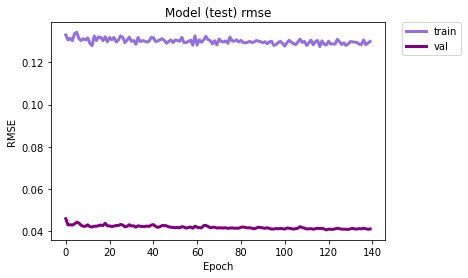

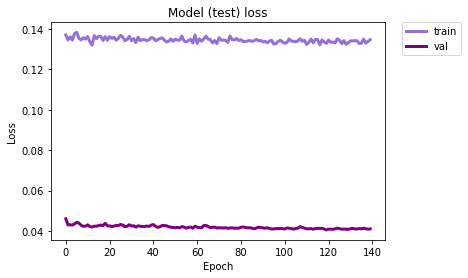

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.9539076
Transformed yhat 47.434578
yhat -0.9544443
Transformed yhat 47.427006
yhat -0.95515615
Transformed yhat 47.41696
yhat -0.955895
Transformed yhat 47.40654
yhat -0.9565693
Transformed yhat 47.397026
yhat -0.9571728
Transformed yhat 47.388515
yhat -0.9577017
Transformed yhat 47.381054
yhat -0.95814157
Transformed yhat 47.374847
yhat -0.95849943
Transformed yhat 47.3698
yhat -0.95878
Transformed yhat 47.36584
yhat -0.9589866
Transformed yhat 47.362923
yhat -0.9591437
Transformed yhat 47.360706
Real data: [46.78431373 46.78431373 46.78431373 47.99968535 47.66605392 46.78431373
 46.78431373 46.78431373 47.11152916 47.99968535 47.99968535 47.99968535
 47.99968535 47.99968535 47.99968535 47.99968535 47.99968535 47.99968535
 47.99968535 47.99968535 47.99968535 47.99968535 47.99968535 47.99968535]
Forecasting values: [47.4, 47.4, 47.4, 47.4, 47.4, 47.4, 47.4, 47.4, 47.4, 47.4, 47.4, 47.4]


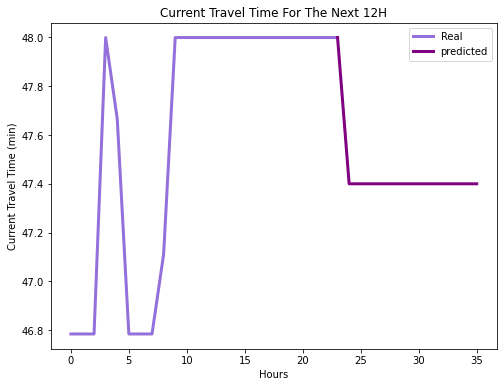

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)
        
#for i in hour:
    #print(i)

In [19]:
import csv

with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N101.4',forecasts[i],hour[i]
        writer.writerow(d)

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 8s 816ms/step - loss: 0.6440 - mae: 0.6243 - rmse: 0.5795 - val_loss: 0.0645 - val_mae: 0.0645 - val_rmse: 0.0645
Epoch 2/300
3/3 [==============================] - 0s 91ms/step - loss: 0.2254 - mae: 0.0762 - rmse: 0.2017 - val_loss: 0.0612 - val_mae: 0.0612 - val_rmse: 0.0612
Epoch 3/300
3/3 [==============================] - 0s 96ms/step - loss: 0.2261 - mae: 0.1348 - rmse: 0.1998 - val_loss: 0.1724 - val_mae: 0.1724 - val_rmse: 0.1724
Epoch 4/300
3/3 [==============================] - 0s 87ms/step - loss: 0.2615 - mae: 0.1992 - rmse: 0.2353 - val_loss: 0.0143 - val_mae: 0.0143 - val_rmse: 0.0143
Epoch 5/300
3/3 [==============================] - 0s 110ms/step - loss: 0.2212 - mae: 0.0955 - rmse: 0.2004 - val_loss: 0.0666 - val_mae: 0.0666 - val_rmse: 0.0666
Epoch 6/300
3/3 [==============================] - 0s 129ms/step - loss: 0.2278 - mae: 0.0794 - rmse: 0.2067 - val_loss: 0.0566 - val_mae: 0.0566 - val_rmse: 0.0566
Epoch 7/300
3

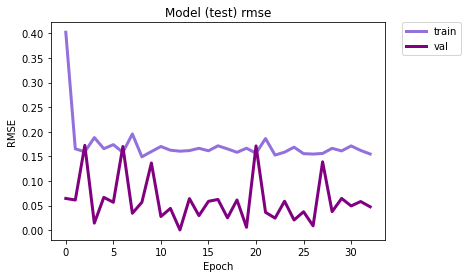

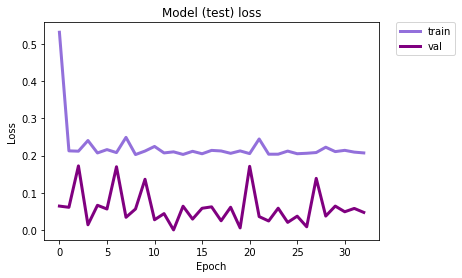

Epoch 1/300
5/5 [==============================] - 0s 105ms/step - loss: 0.2556 - mae: 0.1235 - rmse: 0.2294 - val_loss: 0.0439 - val_mae: 0.0396 - val_rmse: 0.0439
Epoch 2/300
5/5 [==============================] - 0s 86ms/step - loss: 0.2493 - mae: 0.1125 - rmse: 0.2233 - val_loss: 0.0439 - val_mae: 0.0396 - val_rmse: 0.0439
Epoch 3/300
5/5 [==============================] - 0s 92ms/step - loss: 0.2550 - mae: 0.1145 - rmse: 0.2286 - val_loss: 0.0435 - val_mae: 0.0392 - val_rmse: 0.0435
Epoch 4/300
5/5 [==============================] - 0s 83ms/step - loss: 0.2554 - mae: 0.1195 - rmse: 0.2287 - val_loss: 0.0429 - val_mae: 0.0385 - val_rmse: 0.0429
Epoch 5/300
5/5 [==============================] - 0s 86ms/step - loss: 0.2553 - mae: 0.1162 - rmse: 0.2247 - val_loss: 0.0411 - val_mae: 0.0362 - val_rmse: 0.0411
Epoch 6/300
5/5 [==============================] - 0s 98ms/step - loss: 0.2532 - mae: 0.1141 - rmse: 0.2224 - val_loss: 0.0413 - val_mae: 0.0365 - val_rmse: 0.0413
Epoch 7/300
5/5

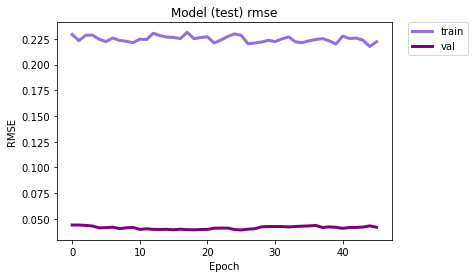

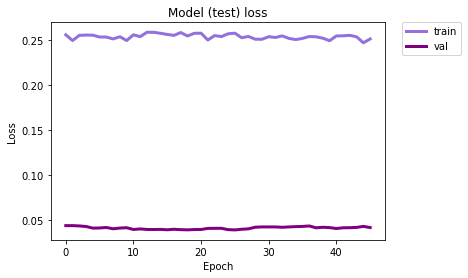

Epoch 1/300
7/7 [==============================] - 0s 74ms/step - loss: 0.1849 - mae: 0.0877 - rmse: 0.1704 - val_loss: 0.0512 - val_mae: 0.0413 - val_rmse: 0.0475
Epoch 2/300
7/7 [==============================] - 0s 62ms/step - loss: 0.1863 - mae: 0.0873 - rmse: 0.1716 - val_loss: 0.0522 - val_mae: 0.0410 - val_rmse: 0.0495
Epoch 3/300
7/7 [==============================] - 0s 68ms/step - loss: 0.1854 - mae: 0.0869 - rmse: 0.1692 - val_loss: 0.0525 - val_mae: 0.0408 - val_rmse: 0.0503
Epoch 4/300
7/7 [==============================] - 0s 65ms/step - loss: 0.1864 - mae: 0.0873 - rmse: 0.1709 - val_loss: 0.0531 - val_mae: 0.0406 - val_rmse: 0.0513
Epoch 5/300
7/7 [==============================] - 0s 61ms/step - loss: 0.1867 - mae: 0.0878 - rmse: 0.1714 - val_loss: 0.0534 - val_mae: 0.0405 - val_rmse: 0.0519
Epoch 6/300
7/7 [==============================] - 0s 61ms/step - loss: 0.1874 - mae: 0.0873 - rmse: 0.1715 - val_loss: 0.0534 - val_mae: 0.0406 - val_rmse: 0.0518
Epoch 7/300
7/7 

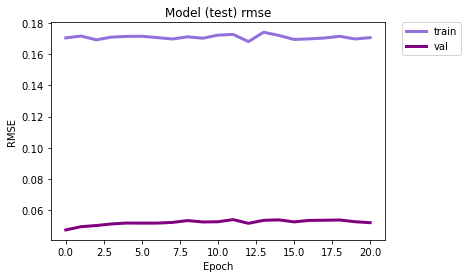

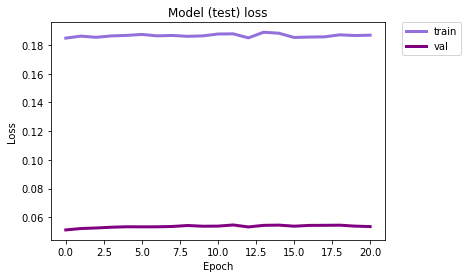

Epoch 1/300
9/9 [==============================] - 1s 93ms/step - loss: 0.1554 - mae: 0.0787 - rmse: 0.1480 - val_loss: 0.0308 - val_mae: 0.0234 - val_rmse: 0.0283
Epoch 2/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1524 - mae: 0.0751 - rmse: 0.1444 - val_loss: 0.0311 - val_mae: 0.0240 - val_rmse: 0.0286
Epoch 3/300
9/9 [==============================] - 1s 84ms/step - loss: 0.1536 - mae: 0.0761 - rmse: 0.1454 - val_loss: 0.0306 - val_mae: 0.0230 - val_rmse: 0.0280
Epoch 4/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1542 - mae: 0.0770 - rmse: 0.1456 - val_loss: 0.0309 - val_mae: 0.0235 - val_rmse: 0.0283
Epoch 5/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1534 - mae: 0.0756 - rmse: 0.1453 - val_loss: 0.0312 - val_mae: 0.0240 - val_rmse: 0.0287
Epoch 6/300
9/9 [==============================] - 1s 79ms/step - loss: 0.1535 - mae: 0.0774 - rmse: 0.1458 - val_loss: 0.0303 - val_mae: 0.0224 - val_rmse: 0.0276
Epoch 7/300
9/9 

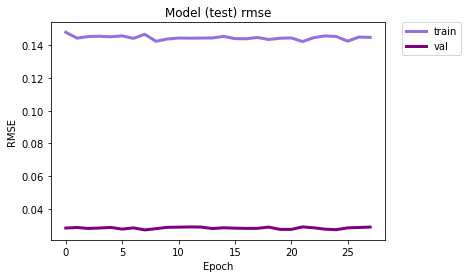

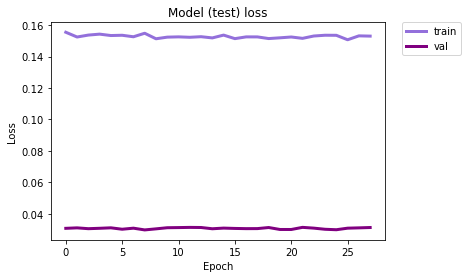

Epoch 1/300
11/11 [==============================] - 1s 90ms/step - loss: 0.1323 - mae: 0.0683 - rmse: 0.1281 - val_loss: 0.0374 - val_mae: 0.0347 - val_rmse: 0.0374
Epoch 2/300
11/11 [==============================] - 1s 83ms/step - loss: 0.1309 - mae: 0.0661 - rmse: 0.1261 - val_loss: 0.0359 - val_mae: 0.0344 - val_rmse: 0.0359
Epoch 3/300
11/11 [==============================] - 1s 81ms/step - loss: 0.1326 - mae: 0.0688 - rmse: 0.1283 - val_loss: 0.0366 - val_mae: 0.0345 - val_rmse: 0.0366
Epoch 4/300
11/11 [==============================] - 1s 78ms/step - loss: 0.1318 - mae: 0.0680 - rmse: 0.1273 - val_loss: 0.0362 - val_mae: 0.0345 - val_rmse: 0.0362
Epoch 5/300
11/11 [==============================] - 1s 108ms/step - loss: 0.1318 - mae: 0.0679 - rmse: 0.1272 - val_loss: 0.0354 - val_mae: 0.0343 - val_rmse: 0.0355
Epoch 6/300
11/11 [==============================] - 1s 117ms/step - loss: 0.1337 - mae: 0.0706 - rmse: 0.1294 - val_loss: 0.0365 - val_mae: 0.0345 - val_rmse: 0.0365
Ep

11/11 [==============================] - 1s 88ms/step - loss: 0.1314 - mae: 0.0687 - rmse: 0.1269 - val_loss: 0.0351 - val_mae: 0.0340 - val_rmse: 0.0352
Epoch 51/300
11/11 [==============================] - 1s 85ms/step - loss: 0.1294 - mae: 0.0674 - rmse: 0.1250 - val_loss: 0.0348 - val_mae: 0.0339 - val_rmse: 0.0349
Epoch 52/300
11/11 [==============================] - 1s 90ms/step - loss: 0.1321 - mae: 0.0692 - rmse: 0.1275 - val_loss: 0.0350 - val_mae: 0.0340 - val_rmse: 0.0351
Epoch 53/300
11/11 [==============================] - 1s 92ms/step - loss: 0.1301 - mae: 0.0670 - rmse: 0.1252 - val_loss: 0.0346 - val_mae: 0.0338 - val_rmse: 0.0347
Epoch 54/300
11/11 [==============================] - 1s 81ms/step - loss: 0.1317 - mae: 0.0698 - rmse: 0.1272 - val_loss: 0.0351 - val_mae: 0.0340 - val_rmse: 0.0352
Epoch 55/300
11/11 [==============================] - 1s 88ms/step - loss: 0.1317 - mae: 0.0701 - rmse: 0.1270 - val_loss: 0.0348 - val_mae: 0.0339 - val_rmse: 0.0349
Epoch 56/30

11/11 [==============================] - 1s 95ms/step - loss: 0.1291 - mae: 0.0663 - rmse: 0.1245 - val_loss: 0.0345 - val_mae: 0.0337 - val_rmse: 0.0346
Epoch 100/300
11/11 [==============================] - 1s 101ms/step - loss: 0.1309 - mae: 0.0689 - rmse: 0.1261 - val_loss: 0.0347 - val_mae: 0.0337 - val_rmse: 0.0347
Epoch 101/300
11/11 [==============================] - 1s 100ms/step - loss: 0.1308 - mae: 0.0685 - rmse: 0.1261 - val_loss: 0.0349 - val_mae: 0.0338 - val_rmse: 0.0350
Epoch 102/300
11/11 [==============================] - 1s 113ms/step - loss: 0.1306 - mae: 0.0691 - rmse: 0.1259 - val_loss: 0.0348 - val_mae: 0.0338 - val_rmse: 0.0348
Epoch 103/300
11/11 [==============================] - 1s 106ms/step - loss: 0.1317 - mae: 0.0682 - rmse: 0.1272 - val_loss: 0.0352 - val_mae: 0.0339 - val_rmse: 0.0353
Epoch 104/300
11/11 [==============================] - 1s 123ms/step - loss: 0.1308 - mae: 0.0682 - rmse: 0.1260 - val_loss: 0.0349 - val_mae: 0.0338 - val_rmse: 0.0350
E

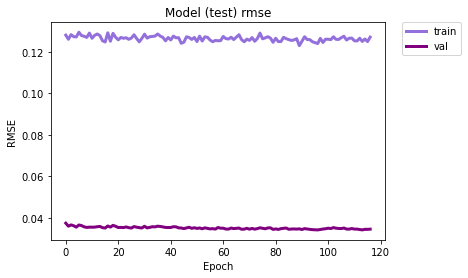

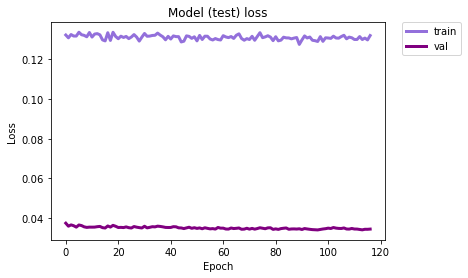

In [21]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat 0.9614957
Transformed yhat 74.45679
yhat 0.9618436
Transformed yhat 74.4617
yhat 0.9623049
Transformed yhat 74.4682
yhat 0.9627817
Transformed yhat 74.47493
yhat 0.96321684
Transformed yhat 74.481064
yhat 0.9635988
Transformed yhat 74.48646
yhat 0.96392345
Transformed yhat 74.491035
yhat 0.96418756
Transformed yhat 74.49477
yhat 0.96439755
Transformed yhat 74.49773
yhat 0.96455914
Transformed yhat 74.5
yhat 0.9646784
Transformed yhat 74.50169
yhat 0.96476746
Transformed yhat 74.502945
Real data: [75.         75.         75.         73.90384615 74.2745098  75.
 75.         75.         74.63461538 74.         74.         74.
 74.         74.         74.         74.         74.         74.
 74.         74.         74.         74.         74.         74.        ]
Forecasting values: [74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5]


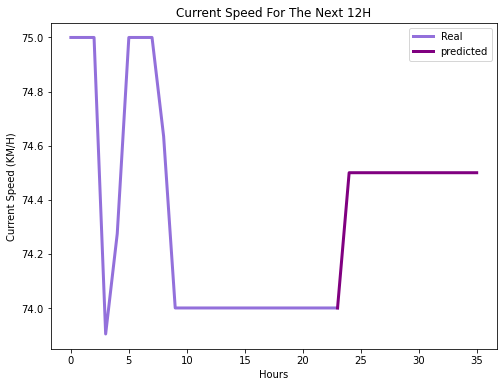

In [22]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [23]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [24]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N101.4',forecastSpeed[i],hour[i]
        writer.writerow(d)
